In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [5]:
app_data = pd.read_csv('hw_aa.csv', sep=';')

Импортруем необходимые библиотеки, считываем данные

In [6]:
app_data.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


Осуществляем предварительную оценку данных (пропуски, число уникальных значений, форма)

In [7]:
app_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         127018 non-null  int64 
 1   uid                127018 non-null  object
 2   experimentVariant  127018 non-null  int64 
 3   version            127018 non-null  object
 4   purchase           127018 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.8+ MB


In [8]:
app_data.nunique()

Unnamed: 0           127018
uid                  127018
experimentVariant         2
version                   4
purchase                  2
dtype: int64

разделим контрольные группы на две серии

In [11]:
x = app_data.query('experimentVariant == 0').purchase
y = app_data.query('experimentVariant == 1').purchase

Запускаем А/А тест

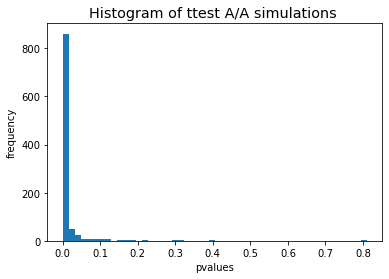

0.934

In [12]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = x.sample(n_s, replace = False).values
    s2 = y.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

по графику видим неравномерное распределение p-value на всех уровнях значимости. Распределенеие заметно скошено вправо. В идеале необходимо получить подобие uniform distribution

Проверим среднее значение заказов в разбивке по версиям приложения и количеству заказов

In [14]:
app_data.groupby(['experimentVariant', 'version'], as_index=False) \
        .agg({'purchase': 'mean', 'uid': 'count'})

,experimentVariant,version,purchase,uid
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Заметна существенная разница в величине среднего значения заказа в контрольных группах при несущественной разнице в количестве закзов для версии приложения v2.8.0.

Проведем повторный А/А тест исключив версию v2.8.0 приложения

In [15]:
x1 = app_data.query('experimentVariant == 0 and version != "v2.8.0"').purchase
y1 = app_data.query('experimentVariant == 1 and version != "v2.8.0"').purchase

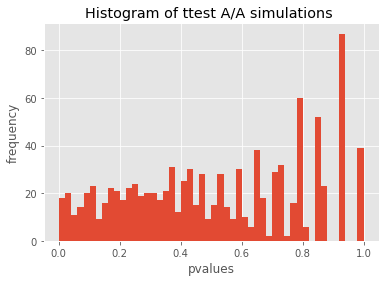

0.042

In [16]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = x1.sample(n_s, replace = False).values
    s2 = y1.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

<b>Вывод:</b> А/А тест сошелся. Проблема связана с версией приложения v2.8.0. Возможно сломан сплит алгоритм. Для окончательного ответа необходимо рассмотреть проблему на стороне реализации сплит алгоритма.